# Quickstart Guide: **Isolating Path Effect for Latent Circuit Discovery**


## **Brief Background**

### What are we looking for?

This library provides a set of functions for discovering **circuits** within Large Language Models (LLMs). In the context of [mechanistic interpretability](https://www.transformer-circuits.pub/2022/mech-interp-essay), a circuit refers to the specific components and connections in a neural network that are responsible for a particular behavior or computation. Circuit discovery aims to isolate and understand these pathways, helping researchers explain how models arrive at their predictions.

By identifying circuits, we can gain insights into the internal mechanisms of LLMs, improve model transparency, and potentially guide model editing or debugging.

The holy grail of circuit discovery would be to isolate the subnetwork components responsible for harmful behavior, from allucinations, to offensive language. This would ideally provide a strong barrier against LLMs risks.

### Why looking for paths?

Recent advances in circuit discovery, such as [Edge Attribution Patching](https://arxiv.org/abs/2310.10348) and [ACDC (Automated Circuit DisCovery)](https://arxiv.org/abs/2304.14997), focus on identifying the specific edges—connections between neurons or attention heads—that contribute to a model's behavior. These methods systematically intervene on model components to measure their causal impact, allowing researchers to map out the computational graph underlying a prediction.

Transformer models, like those used in LLMs, are naturally structured as computational trees: each output can be traced back through a series of operations and connections. By "unrolling" these trees, we can follow individual paths from input to output, attributing behavior to specific sequences of computations.

Empirical observation seem to suggests that **paths often correspond to single behaviors**—for example, a particular reasoning step or token prediction. While superposition (multiple behaviors sharing the same parameters) is a known challenge in neural networks, path-based analysis frequently reveals that certain behaviors are localized to distinct computational routes. This supports the claim that isolating paths can help us understand and manipulate specific model behaviors, even if some degree of superposition remains.

Another interesting advantage of looking for paths is that they highlight the flows of specific information which is often interpretable with simple decoding methods like [logit lens](https://www.lesswrong.com/posts/AcKRB8wDpdaN6v6ru/interpreting-gpt-the-logit-lens)

## **Usage**

### Installation

#### Via pip

To install the library using `pip` you can run:

`pip install ipe`

#### Via git repository

To install the library from git you first need to download the repository:

`git clone https://github.com/andreac01/IPE-LatentCircuitIdentification.git` if using https or
`git@github.com:andreac01/IPE-LatentCircuitIdentification.git` if using ssh

Then open the cloned repository, finally to install the package run:

`pip install -e .`

Now you should be able to import the package in any script you want by writing `import ipe` at the top of your python file

### Models

The code in this repository is compatible with models from transformer-lens which is built on top of PyTorch. You can install it via pip:
```bash
pip install transformer-lens
```

Here we provide a simple example of how you could load a model using the library.
For more details consult the [official transformer-lens documentation](https://transformerlensorg.github.io/TransformerLens/)

In [12]:
%load_ext autoreload
%autoreload 2

In [4]:
import torch
from transformer_lens import HookedTransformer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HookedTransformer.from_pretrained('gpt2-small', device=device, torch_dtype=torch.float32, center_unembed=True)

Loaded pretrained model gpt2-small into HookedTransformer


### Experiment Setup

The class `ExperimentManager` can be used to find the most contributing, visualize and analyze them.
The ExperimentManager have many parameters, however for simplicity most of them have default value. You can consult our API reference for a more complete brakdown of them.

The key parameters are:
 - model: the transformer-lens model to be studied
 - prompts: a list of prompts, we suggest to use small batches to avoid excessive memory consumption
 - targets: the list of target completions of the prompt
 - cf_prompts / cf_targets: optional parameters to be provided when using counterfactual
 - metric: the string corresponding to the metric function to be used. Options are 'target_logit_percentage', 'target_probability_percentage', 'logit_difference', 'kl_divergence', or 'indirect_effect'. Defaults to 'target_logit_percentage'
 - algorithm: the search algorithm to be used. Options are 'PathAttributionPatching' or 'IsolatingPathEffect'. Defaults to 'PathAttributionPatching'.
 - search_strategy: The search strategy to use within the chosen algorithm. Options are 'Threshold', 'BestFirstSearch', or 'LimitedLevelWidth'. Defaults to 'BestFirstSearch'.

Furthermore you can pass custom parameters to initialize the metric and/or algorithm by passing them as a dictionary. You can consult the API reference to see which parameters they expect.

In [5]:
from ipe.experiment import ExperimentManager

experiment = ExperimentManager(
    model=model,
    prompts=['When John and Mary went to the shops. John gave the bag to'],
    targets=[' Mary'],
    cf_prompts=['When John and Mary went to the shops. Mary gave the bag to'], # Not required, default is []
    cf_targets=[' John'], # Not required, default is []
    positional_search=True, # Not required, default is False
    metric='target_logit_percentage', # Not required, default is 'target_logit_percentage'
    metric_params={}, # Not required, default is {}
    patch_type='zero', # Not required, default is 'auto' which uses the counterfactual prompt if provided. Zero does not use the counterfactual prompt
    # Other params...
)

### Exeriment Run and Visualization

The experiment class once initialized offer a fast way to run experiments and a simple way to visualize circuits and messages

#### Running The Experiment

In [6]:
experiment.run(return_paths=False)

Completed paths: 100%|██████████| 100/100 [01:14<00:00,  1.33it/s]


#### Visualizing the Paths

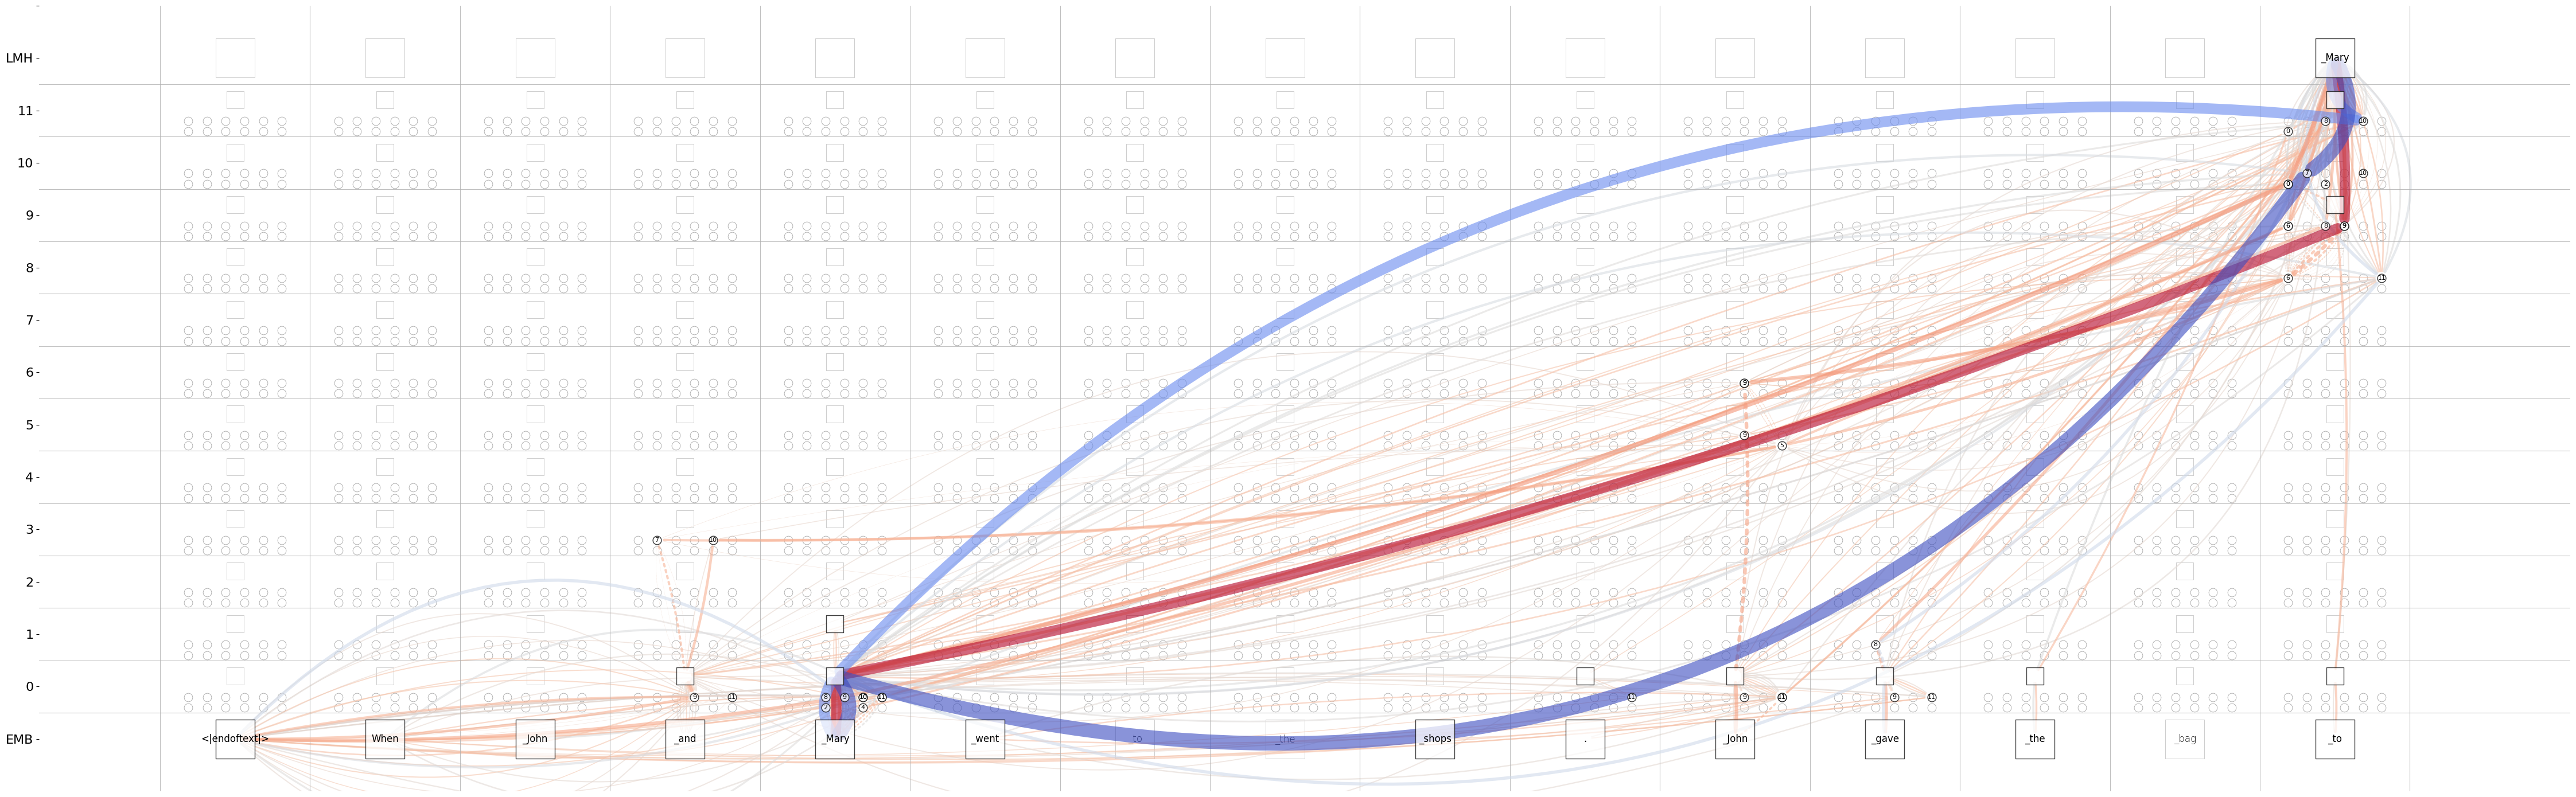

In [16]:
experiment.plot(heads_per_row=6)

#### Inspecting a Path

In [17]:
experiment.decode_paths()